# Model Traing

In this notebook we try to train a LSTM with the gathered data from the simulation.

## Imports

In [ ]:
!pip install fuzzy-match
!pip install -q -U keras-tuner

from fuzzy_match import match
from fuzzy_match import algorithims

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import keras_tuner as kt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

#from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential #Add tensorflow.keras for hyperparameter training 
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



import re
import csv

import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
from keras.models import load_model

In [ ]:
drive.flush_and_unmount()

In [ ]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


## File Upload

In [ ]:
data_path = "/content/gdrive/MyDrive/Sentiment/clean_data_nostem.csv"

### Import the data from our simulation

In [ ]:
import io
df_sim = pd.read_csv(data_path)
df_sim["tokens"] = df_sim["tokens"].apply(eval)
df_sim

FileNotFoundError: ignored

### Import friends dataset

In [ ]:
# data friends
data_path2 = "/content/gdrive/My Drive/Sentiment/clean_data_friends_no_stemming.csv"
df_friends = pd.read_csv(data_path2)
df_friends

,ID,body,emotion,conversation_id,joy,trust,fear,surprise,sadness,disgust,anger,anticipation,neutral,tokens
0,10,ich bin wieder in der highschool stehe mitten ...,neutral,559,0,0,0,0,0,0,0,0,1,"['highschool', 'stehe', 'mitten', 'cafeteria']"
1,12,den traum hatte ich auch schon mal,neutral,559,0,0,0,0,0,0,0,0,1,"['traum', 'mal']"
2,13,dann schaue ich runter und erkenne dass da ein...,surprise,559,0,0,0,1,0,0,0,0,0,"['schaue', 'runter', 'erkenne', 'telefon']"
3,17,ganz plötzlich fängt das telefon an zu klingeln,neutral,559,0,0,0,0,0,0,0,0,1,"['plötzlich', 'fängt', 'telefon', 'klingeln']"
4,20,hi,neutral,75,0,0,0,0,0,0,0,0,1,['hi']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9145,84294,es hat mir geholfen dein gesicht in der menge ...,joy,610,1,0,0,0,0,0,0,0,0,"['geholfen', 'gesicht', 'menge', 'sehen']"
9146,84397,tja ich werde jetzt sehen ob ich ein zimmer be...,neutral,1,0,0,0,0,0,0,0,0,1,"['tja', 'sehen', 'zimmer', 'bekommen']"
9147,84441,glaubst du ja,neutral,162,0,0,0,0,0,0,0,0,1,['glaubst']
9148,84442,glaubst du das wirklich ja,neutral,162,0,0,0,0,0,0,0,0,1,['glaubst']


### Import facebook data

In [ ]:
data_path3 = "/content/gdrive/My Drive/Sentiment/clean_data_fb_no_stemming.csv"
df_fb = pd.read_csv(data_path3)
df_fb

,body,emotion,conversation-id,joy,trust,fear,surprise,sadness,disgust,anger,anticipation,neutral,tokens
0,entschuldigen sie die störung aber haben sie d...,neutral,0,0,0,0,0,0,0,0,0,1,"['entschuldigen', 'störung', 'lehrbuch', '270']"
1,digitales design und prinzipien ich denke,neutral,0,0,0,0,0,0,0,0,0,1,"['digitales', 'design', 'prinzipien', 'denke']"
2,das glaube ich nicht,neutral,0,0,0,0,0,0,0,0,0,1,['glaube']
3,ich könnte falsch liegen,neutral,0,0,0,0,0,0,0,0,0,1,"['falsch', 'liegen']"
4,ok das ist in ordnung ich bemühe mich nur nich...,neutral,0,0,0,0,0,0,0,0,0,1,"['ok', 'ordnung', 'bemühe', 'bücher', 'bezahlen']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9857,es ist young money,neutral,719,0,0,0,0,0,0,0,0,1,"['young', 'money']"
9858,oh ich habe in der nähe der 73er nach unten ge...,surprise,719,0,0,0,1,0,0,0,0,0,"['oh', 'nähe', '73er', 'unten', 'geschaut']"
9859,sie sind bei 86,neutral,719,0,0,0,0,0,0,0,0,1,['86']
9860,ja aber ich weiß nicht ob die 15 die man für d...,neutral,719,0,0,0,0,0,0,0,0,1,"['weiß', '15', 'verspätete', 'abgabe', 'abgezo..."


In [ ]:
df_fb = df_fb.rename(columns={'conversation-id': 'conversation_id'})
df_fb

,body,emotion,conversation_id,joy,trust,fear,surprise,sadness,disgust,anger,anticipation,neutral,tokens
0,entschuldigen sie die störung aber haben sie d...,neutral,0,0,0,0,0,0,0,0,0,1,"['entschuldigen', 'störung', 'lehrbuch', '270']"
1,digitales design und prinzipien ich denke,neutral,0,0,0,0,0,0,0,0,0,1,"['digitales', 'design', 'prinzipien', 'denke']"
2,das glaube ich nicht,neutral,0,0,0,0,0,0,0,0,0,1,['glaube']
3,ich könnte falsch liegen,neutral,0,0,0,0,0,0,0,0,0,1,"['falsch', 'liegen']"
4,ok das ist in ordnung ich bemühe mich nur nich...,neutral,0,0,0,0,0,0,0,0,0,1,"['ok', 'ordnung', 'bemühe', 'bücher', 'bezahlen']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9857,es ist young money,neutral,719,0,0,0,0,0,0,0,0,1,"['young', 'money']"
9858,oh ich habe in der nähe der 73er nach unten ge...,surprise,719,0,0,0,1,0,0,0,0,0,"['oh', 'nähe', '73er', 'unten', 'geschaut']"
9859,sie sind bei 86,neutral,719,0,0,0,0,0,0,0,0,1,['86']
9860,ja aber ich weiß nicht ob die 15 die man für d...,neutral,719,0,0,0,0,0,0,0,0,1,"['weiß', '15', 'verspätete', 'abgabe', 'abgezo..."


## Create Context driven data for simulation and friends data

### Concat context tokens



In [ ]:
'''Create context for messages in a certain windowsize'''
def create_context(df, ws):
  contexts = []
  for index, row in df.iterrows():
    context = row['tokens']
    for i in range(1, ws):
      if ((index - i) < 0) or (df.loc[index - i]['conversation_id'] != row['conversation_id']):
        break
      else:
        context = df.loc[index - i]['tokens'] + context
    contexts.append(context)
  return contexts

Create context column for all datasets.

In [ ]:
df_sim["context"] = create_context(df_sim, 4)
df_fb["context"] = create_context(df_fb, 4)
df_friends["context"] = create_context(df_friends, 4)

### Merge and cut datasets

In [ ]:
#Merge Data
df1 = df_sim.append(df_friends, ignore_index=True)
df2 = df1.append(df_fb, ignore_index=True)
df = df2

#Slice dataframe
df = df[['context', 'joy', 'trust', 'fear', 'surprise', 'sadness', 'disgust', 'anger', 'anticipation']]

#Filter useless rows
df = df.drop(df[(df.joy == 0) & (df.trust == 0) & (df.fear == 0) & (df.surprise == 0) & (df.sadness == 0) & (df.disgust == 0) & (df.anger == 0) & (df.anticipation == 0)].index)
df

,context,joy,trust,fear,surprise,sadness,disgust,anger,anticipation
0,[hey],0,0,0,0,0,0,1,0
1,"[hey, hey]",0,0,0,0,0,0,0,1
2,"[hey, ,, sag, mal, bleibst, ?, ziemlich, spät,...",0,0,0,0,1,0,1,0
3,"[hey, ,, sag, mal, bleibst, ?, ziemlich, spät,...",0,0,0,0,1,0,0,0
4,"[hey, ,, sag, mal, bleibst, ?, ziemlich, spät,...",0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
22588,"['verdammt', 'mal']['14']['13']['1']",0,0,0,1,0,0,0,0
22589,"['14']['13']['1']['idk', 'lmao', 'omg']",1,0,0,0,0,0,0,0
22602,"['person_343']['geschlafen']['8']['oh', 'schei...",0,0,0,1,0,0,0,0
22607,"['malloc', 'arbeiten']['oh', '15', 'rabatt', '...",0,0,0,1,0,0,0,0


## Tokenization

Load Glove embeddings

In [ ]:
embeddings_index = {}
glove_file = "/content/gdrive/My Drive/Sentiment/vectors.txt" 
with open(glove_file) as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Found 1309281 word vectors.


In [ ]:
word_list = []
glove_file = "/content/gdrive/My Drive/Sentiment/common_words.txt" 
with open(glove_file) as f:
  for line in f:
    values = line.split()
    word = values[1]
    word_list.append(word)
print('Found %s words.' % len(word_list))
print(word_list)

Found 20415 words.
['!', '"', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '=', '>', '?', '@', '[', ']', '»', '„', 'der', 'die', 'Die', 'ist', 'Das', 'in', 'Der', 'den', 'auf', 'das', 'ein', 'werden', 'Sie', 'eine', 'und', 'mit', 'von', 'wird', 'für', 'des', 'sind', 'sich', 'es', 'dem', 'nicht', 'im', 'wurde', 'war', 'an', 'zu', 'Es', 'auch', 'aus', 'hat', 'einen', 'Ein', 'einer', 'um', 'noch', 'sie', 'Eine', 'bei', 'einem', 'Er', 'er', 'Prozent', 'nach', 'In', 'über', 'Wir', 'Euro', 'haben', 'durch', 'Auch', 'vor', 'ich', 'gibt', 'am', 'wir', 'nur', 'Ich', 'wurden', 'kann', 'Diese', 'sei', 'aber', 'soll', 'hatte', 'können', 'waren', 'Im', 'zum', 'Für', 'Und', 'wieder', 'zur', 'ab', 'Mit', 'hier', 'keine', 'geht', 'sehr', 'sein', 'als', 'Was', 'Aber', 'dann', 'gibt', 'Hier', 'Wie', 'gegen', 'schon', 'jedoch', 'immer', 'Dies', 'So', 'Doch', 'habe', 'Jetzt', 'Bei', 'liegt', 'nun', 'kommt', 'mehr', 'müssen', 'neue', 'unter', 'Uhr', 'muss', 'jetzt', 'Am', 'bis', 'eines'

In [ ]:
word_tokens = np.append(df["context"].values, list(word_list))
print(len(word_tokens))
print(word_tokens)
with open("/content/gdrive/My Drive/Sentiment/all_words.txt", "w") as output:
    output.write(str(values))

31204
[list(['hey']) list(['hey', 'hey'])
 list(['hey', ',', 'sag', 'mal', 'bleibst', '?', 'ziemlich', 'spät', 'dran', 'echt', 'schön', 'kalt'])
 ... 'üblich' 'übliche' 'üblichen']


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

#Tokenization of the words of our dataset and append them with the Glove words
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, split=' ', oov_token='<unw>', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\'')
tokenizer.fit_on_texts(word_tokens)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(df['context'].values)
# we then pad the sequences so they're all the same length (sequence_length)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
#Slicing labels to vectors
Y = df[['joy', 'trust', 'fear', 'surprise', 'sadness', 'disgust', 'anger', 'anticipation']]
print('Shape of label tensor:', Y.shape)
print(df['context'].values)

Found 25012 unique tokens.
Shape of data tensor: (10789, 250)
Shape of label tensor: (10789, 8)
[list(['hey']) list(['hey', 'hey'])
 list(['hey', ',', 'sag', 'mal', 'bleibst', '?', 'ziemlich', 'spät', 'dran', 'echt', 'schön', 'kalt'])
 ... "['person_343']['geschlafen']['8']['oh', 'scheiße', 'glück']"
 "['malloc', 'arbeiten']['oh', '15', 'rabatt', 'genommen']['86', '731']['verdammt', 'schön', 'segregierte', 'listen']"
 "['name', 'anzeigetafel']['idk', '1155', 'eingereicht', 'ergebnis', 'schlief']['young', 'money']['oh', 'nähe', '73er', 'unten', 'geschaut']"]


In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## GloVe

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 25012 unique tokens.


In [ ]:
num_words = len(word_index) + 1
print(num_words)

unknown_words = 0

embedding_dim = 300

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

unkn_words = []

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # we found the word - add that words vector to the matrix
      embedding_matrix[i] = embedding_vector
    #elif str(word).match('\d+'):
    # embedding_matrix[i] = embeddings_index.get('nummer')
    else:
      unknown_words += 1
      #doesn't exist, assign a random vector
      new_embedding_vector_rdm = np.random.randn(embedding_dim)
      embedding_matrix[i] = new_embedding_vector_rdm
      unkn_words.append(str(word))

print(unkn_words)

25013
['<unw>', ',', '?', '!', '.', '...', '..', '1', '-', '2', '3', '....', 'd', 'p', '5', '6', '20', '10', 'u', '4', 'c', '0', '12', '8', '"', 'o', '30', '15', 'lmao', '  ', '9', "geht's", '16', '50', '7', '17', '14', 's', ':', 'r', 'b', '18', '13', 'mhmhm', 'i', '11', '00', 'ohje', 'ohhh', 'garnicht', 'waaaaas', 'soooo', '19', '1,7', 'hahahaha', '40', 'm', '*', 'master-branch', 'pheebs', '25', '000', 'jaaaa', 'y', 'e', '(', ')', 'mousies', '23', '21', '100', 'meintest', '28', '31', '22', 'ohhhh', 'n', '26', '45', 't', 'hahah', '200', '80', 'g', 'iunagii', 'k', ':)', 'schwangerschaftstest', '97', '35', 'lolol', '90', 'sooooo', 'niee', 'ohja', "gibt's", 'kaiserschmarren', 'frägst', 'achso', 'user17', '48', '3,7', 'bewerbungsgespräch', 'versprachst', 'wesleyi', '88', 'l', '24', 'ihalloi', 'räuspert', 'supergroße', 'glaubs', '27', '46', '70', '500', '43', '207', 'hmmm', 'waaas', 'x', 'wahhh', '32', '430', 'loool', '20min', '/', 'freust', 'portmonnaie', 'cheesei', 'yessss', 'woah', '120'

In [ ]:
# dictionary of lists  
dict = {'name': unkn_words}  
       
df_unnknown = pd.DataFrame(dict) 
#df_unnknown = df_unnknown[(df_unnknown.name.str.match('[a-z]{2,}'))]
df_unnknown
# saving the dataframe 
#df_unnknown.to_csv('/content/gdrive/MyDrive/Sentiment/GFG.csv') 

,name
0,<unw>
1,","
2,?
3,!
4,.
...,...
4994,übungsschwerpunkt
4995,überdimensioniertes
4996,übereste
4997,überseht


## Train-Test-Split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9710, 250) (9710, 8)
(1079, 250) (1079, 8)


In [ ]:
MAX_NB_WORDS

50000

## Model Training

### 8 Emotion LSTM

In [ ]:
model = Sequential()
#model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Embedding(num_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=X.shape[1], trainable=False))
#Dropout L
model.add(SpatialDropout1D(0.5))
#LSTM (not pretrained yet)
model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.1)))
#Dense with 8 outputs, because we have 8 different emotions as labels
model.add(Dense(8, activation='sigmoid'))
model.add(Activation('sigmoid'))
print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 300)          7503900   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 8)                 1608      
Total params: 7,826,308
Trainable params: 322,408
Non-trainable params: 7,503,900
_________________________________________________________________
None
Epoch 1/20
137/137 [==============================] - 193s 1s/step - loss: 0.4369 - accuracy: 0.3122 - val_loss: 0.3328 - val_accuracy: 0.3594
Epoch 2/20
137/137 [==============================] - 167s 1s/step - loss: 0.3362 - accura

### Hyperparameter Tuning

Build hyperparameter tuneable model



In [ ]:
def model_builder(hp):
  
  # Tune the number of dropouts in the Dropout layer and the LSTM
  hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.3, step=0.1)
  # Tune the number of dropout and recurrent dropout in the LSTM
  hp_lst_dropout = hp.Float('lstm_dropout', min_value=0.4, max_value=0.6, step=0.1)
  hp_recurrent_dropout = hp.Float('rec_dropout', min_value=0.1, max_value=0.2, step=0.1)
  # Tune the number of units in the LSTM layer
  hp_units = hp.Int('units', min_value=160, max_value=224, step=32)

  model = Sequential()
  #model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  model.add(Embedding(num_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=X.shape[1], trainable=False))
  #Dropout L
  model.add(SpatialDropout1D(rate=hp_dropout))
  model.add(Bidirectional(LSTM(units=hp_units, dropout=hp_lst_dropout, activation='relu', recurrent_dropout=hp_recurrent_dropout, return_sequences=True)))
  model.add(Bidirectional(CuDNNLSTM(64)))
  model.add(Dropout(rate=hp_dropout))
  #Dense with 8 outputs, because we have 8 different emotions as labels
  model.add(Dense(8, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=15,
                     factor=3)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

In [ ]:
tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 27 Complete [01h 20m 42s]
accuracy: 0.40950050950050354

Best accuracy So Far: 0.40950050950050354
Total elapsed time: 08h 51m 22s

Search: Running Trial #28

Hyperparameter    |Value             |Best Value So Far 
dropout           |0.6               |0.4               
lstm_dropout      |0.5               |0.6               
rec_dropout       |0.1               |0.2               
units             |384               |32                
tuner/epochs      |15                |15                
tuner/initial_e...|0                 |0                 
tuner/bracket     |0                 |0                 
tuner/round       |0                 |0                 

Epoch 1/15
101/243 [===========>..................] - ETA: 3:12 - loss: nan - accuracy: 0.3475

In [ ]:
tuner.results_summary()

In [ ]:
models = tuner.get_best_models(num_models=3)

In [ ]:
i = 1
for model in models:
  modelname = '/content/gdrive/My Drive/models/model_hyper_pos_' + str(i) + '.h5'
  model.save(modelname)
  i += 1

### Save model

In [ ]:
model.save('/content/gdrive/My Drive/models/model_merged.h5')

In [ ]:
import time
t = time.time()

export_path_keras = "/content/gdrive/My Drive/models/model_{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

/content/gdrive/My Drive/models/model_1626201053.h5


## Evaluation

In [ ]:
model2 = load_model("/content/gdrive/My Drive/models/model_1626201053.h5")
y_hat = model2.predict(X_test)

In [ ]:
res=list(map(lambda x: np.argmax(x), Y_test.values))
pred = list(map(lambda x: np.argmax(x), y_hat))
accuracy_score(res, pred)

0.4077849860982391

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision: [0.61386139 0.36842105 0.         0.31284916 0.31034483 0.5
 0.23265306 0.27027027]
recall: [0.60635697 0.3559322  0.         0.35897436 0.23684211 0.04347826
 0.40425532 0.46511628]
fscore: [0.6100861  0.36206897 0.         0.33432836 0.26865672 0.08
 0.29533679 0.34188034]
support: [409  59  73 156 152  46 141  43]
accuracy: 0.4077849860982391


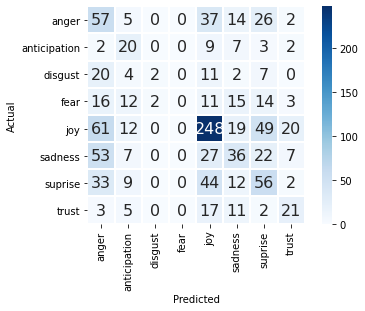

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

label_list=res
pred_list=pred
precision, recall, fscore, support = score(label_list, pred_list)
acc=accuracy_score(label_list, pred_list)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('accuracy: {}'.format(acc))

index_to_emotion = {0: 'joy', 1: 'trust', 2: 'fear', 3: 'suprise', 4: 'sadness', 5: 'disgust', 6: 'anger', 7: 'anticipation'}
cf_matrix = confusion_matrix(label_list, pred_list)
names = [index_to_emotion[x] for x in np.unique(label_list)]
df_cm = pd.DataFrame(cf_matrix, columns=names, index = names)
df_cm = df_cm.reindex(sorted(df_cm.columns), axis=1)
# sort by index labels
df_cm = df_cm.sort_index(axis = 0)

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt = 'g', square=2, linewidth=1.)
plt.show()